Last notebook to run, and can customize to for specifc portoflio analysis

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import os 

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
    
print(f'Current Working Directory: {os.getcwd()}')

from utils.config import chosen_portfolio
from utils.finance_utils import plot_cum_ret

chosen_portfolio

Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py
Updated on 06/04/2025 5:56


ImportError: cannot import name 'chosen_portfolio' from 'utils.config' (/Users/blakeuribe/Desktop/portfolio_py/utils/config.py)

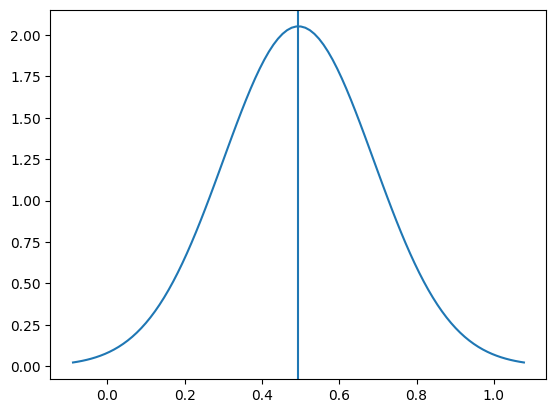

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = chosen_portfolio['Expected Portfolio Return']
sigma = chosen_portfolio['Expected Portfolio Standard Deviation']
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(x=mu)
plt.show()

In [ ]:
# Functions

def merge_stock_df(stocks: list, stock_weights: list, existing_df: pd.DataFrame, paper_money: float) -> pd.DataFrame:
    """
    Merge existing valuation DataFrame with a simulated portfolio.
    
    Parameters:
    stocks (list): List of stock tickers in the portfolio.
    stock_weights (list): Corresponding weight allocations for each stock.
    existing_df (pd.DataFrame): DataFrame containing stock valuation data.
    paper_money (float): Total portfolio value, default is $30,000.
    
    Returns:
    pd.DataFrame: Merged DataFrame containing stock tickers, allocations, and valuation data.
    """
    real_allocation = dict(zip(np.array(stocks), (np.array(stock_weights)*paper_money)))
    real_allocation_df = pd.DataFrame(list(real_allocation.items()), columns=['Tickers', 'Weights_dollar'])
    
    merged_df = pd.merge(left=real_allocation_df, right=existing_df, on='Tickers', how='left')
    
    return merged_df.sort_values(by='Weights_dollar', ascending=False)




def get_stock_info(stocks: list, info_to_get: list) -> pd.DataFrame:
    if len(stocks) > 50:
        return 'Please set up logging, before getting info'
    
    end_list = []  # List of dictionaries

    for stock in stocks:
        stock_info = yf.Ticker(stock).info
        stock_data = {val: stock_info.get(val) for val in info_to_get}
        stock_data['Tickers'] = stock  # Add ticker symbol
        end_list.append(stock_data)  
        
    df = pd.DataFrame(end_list)
    
    if 'exDividendDate' or 'earningsTimestamp' in df.columns:
        df['exDividendDate'] = pd.to_datetime(df['exDividendDate'], unit='s')
        df['earningsTimestamp'] = pd.to_datetime(df['earningsTimestamp'], unit='s')

    # Convert list of dictionaries into DataFrame
    return df


def check_optionable(ticker: str) -> bool:
    try:
        return not yf.Ticker(ticker).option_chain().calls.empty
    except Exception:
        return False

In [ ]:
CASH = 	33_000.00 # adjust cash here to see dollar avraging cost

valuation_df = pd.read_csv('data/clean/filtered_valuation_df.csv')
portfolio = merge_stock_df(chosen_portfolio['Stocks'], chosen_portfolio['Stock Weights'], valuation_df, paper_money=CASH)

vals_to_get = ['industry', 'beta', 'averageAnalystRating', 
               'country', 'dividendYield', 'exDividendDate', 
               'overallRisk', 'currentPrice', 'earningsTimestamp', 
               'currentRatio', 'debtToEquity'
] # KPI's to get from yf

In [ ]:
valuation_df

,Tickers,Sector,marketCap,trailingPE,forwardPE,profitMargins,trailingEps,quickRatio,earningsQuarterlyGrowth,Sharpe_ratios,Date_Collected
0,BABA,Consumer Cyclical,2.593549e+11,14.532085,11.013171,0.13059,7.48,1.158,2.732,1.256170,2025-06-15
1,MMM,Industrials,8.230940e+10,19.046078,19.359493,0.17791,8.03,1.114,0.203,1.297640,2025-06-15
2,MPLX,Energy,5.210163e+10,11.787529,11.573697,0.38998,4.33,1.027,0.120,1.503437,2025-06-15
3,GRMN,Technology,4.135203e+10,28.333775,28.789545,0.22762,7.58,2.615,0.206,0.901269,2025-06-15
4,ANYYY,Industrials,4.017885e+10,16.910257,8.912162,0.33547,0.78,1.218,0.154,1.266057,2025-07-04
5,EBAY,Consumer Cyclical,3.519005e+10,18.355770,14.628353,0.19783,4.16,1.072,0.148,1.002590,2025-07-04
6,CHKP,Technology,2.423456e+10,29.502640,22.497990,0.32746,7.58,1.043,0.038,1.234018,2025-07-04
7,TPR,Consumer Cyclical,1.873364e+10,23.736841,18.949577,0.12497,3.80,0.976,0.458,1.275293,2025-07-04
8,AU,Basic Materials,2.354642e+10,15.214984,16.985455,0.21093,3.07,1.359,6.638,1.510958,2025-07-04
9,KGC,Basic Materials,1.945705e+10,16.183672,18.022726,0.21740,0.98,1.146,2.439,2.088090,2025-07-04


In [ ]:
stock_info_sharpe = get_stock_info(portfolio['Tickers'].to_list(), vals_to_get) # df of val to get, and respective values
complete_portfolio_info = pd.merge(left=portfolio, right=stock_info_sharpe, left_on='Tickers', right_on='Tickers')
complete_portfolio_info['Is_optionable'] = complete_portfolio_info['Tickers'].apply(check_optionable)

In [ ]:
complete_portfolio_info['Num_of_shares'] = complete_portfolio_info['Weights_dollar']/complete_portfolio_info['currentPrice'] # simply seeing total num of shares for avaibale option strategies
complete_portfolio_info.sort_values(by='Weights_dollar', ascending=False) # Note: with dollar cost averaging, num of shares is only a approx. as price flucates

,Tickers,Weights_dollar,Sector,marketCap,trailingPE,forwardPE,profitMargins,trailingEps,quickRatio,earningsQuarterlyGrowth,...,country,dividendYield,exDividendDate,overallRisk,currentPrice,earningsTimestamp,currentRatio,debtToEquity,Is_optionable,Num_of_shares
0,FFIV,13158.274706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,United States,NaN,NaT,2.0,300.13,2025-04-28 20:05:00,1.533,8.051,True,43.841918
1,EXEL,8108.460198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,United States,NaN,NaT,1.0,46.15,2025-05-13 20:07:00,3.499,8.781,True,175.697946
2,THC,5993.680709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,United States,NaN,2000-03-13,1.0,171.50,2025-07-22 12:30:00,1.778,152.202,True,34.948576
3,FUTU,3712.942894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Hong Kong,NaN,2024-12-06,NaN,121.79,2025-05-29 08:00:00,1.158,37.091,True,30.486435
4,FOXA,1480.604051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,United States,0.96,2025-03-05,10.0,56.25,2025-05-12 12:00:20,2.453,68.321,True,26.321850
5,MLI,944.591440,Industrials,9.144116e+09,15.052824,15.592452,0.1592,5.49,3.126,0.138,...,United States,1.26,2025-06-06,4.0,82.64,2025-04-22 11:00:00,4.295,1.225,True,11.430197
6,SNA,394.392110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,United States,2.75,2025-05-20,6.0,321.63,2025-04-17 10:30:00,4.142,23.477,True,1.226229
7,COKE,257.539340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,United States,0.90,2025-04-25,9.0,117.71,2025-04-30 20:10:00,2.026,126.853,True,2.187914


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  9 of 9 completed


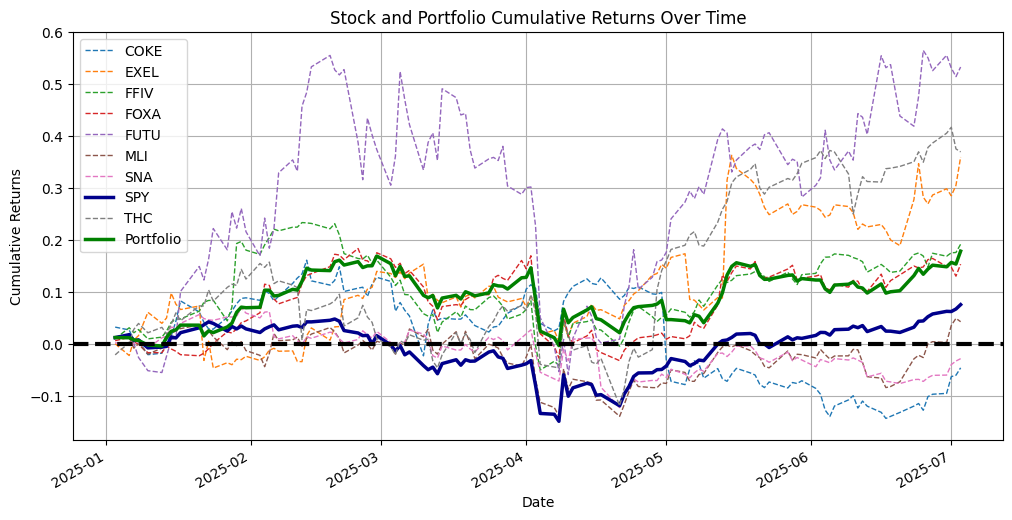

In [ ]:
# plot stress test on portfolio, against a benchmark

stress_start = '2025-01-01'
stress_end = '2026-01-01'

plot_cum_ret(chosen_portfolio['Stocks'], chosen_portfolio['Stock Weights'], start_date=stress_start, end_date=stress_end)

([<matplotlib.patches.Wedge at 0x110c59650>,
 [Text(-1.0162675555991008, 0.4209516070008866, 'United States'),
  Text(1.016267492037165, -0.4209517604530134, 'Hong Kong')],
 [Text(-0.5543277575995095, 0.22960996745502898, '87.5%'),
  Text(0.5543277229293626, -0.2296100511561891, '12.5%')])

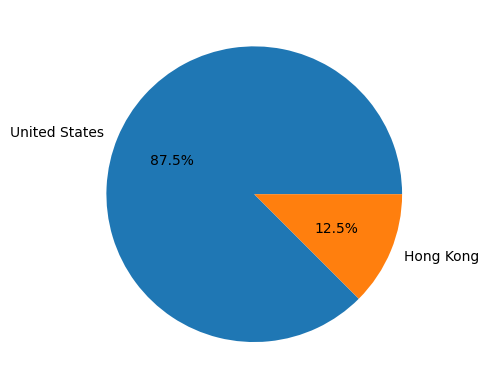

In [ ]:
import matplotlib.pyplot as plt
countries = complete_portfolio_info['country'].value_counts()
plt.pie(countries.values, labels=countries.index, autopct='%1.1f%%')

# sectors = complete_portfolio_info['Sector'].value_counts()
# plt.pie(sectors.values, labels=sectors.index, autopct='%1.1f%%')

# ratings = complete_portfolio_info['averageAnalystRating'].str.split(' - ', expand=True)[1].value_counts()
# plt.pie(ratings.values, labels=ratings.index, autopct='%1.1f%%')

In [ ]:
yf.Ticker('msft').info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'website': 'https://www.microsoft.com',
 'industry': 'Software - Infrastructure',
 'industryKey': 'software-infrastructure',
 'industryDisp': 'Software - Infrastructure',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power 

In [ ]:
from datetime import datetime

earnings_time = datetime.fromtimestamp(1746534600)
print("Earnings Report:", earnings_time)

call_time = datetime.fromtimestamp(1746538200)
print("Earnings Call:", call_time)

Earnings Report: 2025-05-06 05:30:00
Earnings Call: 2025-05-06 06:30:00
